# Step 1: Acquire Data

## Install Libraries / Configure Settings

In [1]:
!pip list

Package                           Version
--------------------------------- ------------------
absl-py                           2.3.1
accelerate                        1.8.1
aext-assistant                    4.20.0
aext-assistant-server             4.20.0
aext-core                         4.20.0
aext-core-server                  4.20.0
aext_environments_server          4.20.0
aext-panels                       4.20.0
aext-panels-server                4.20.0
aext-project-filebrowser-server   4.20.0
aext-share-notebook               4.20.0
aext-share-notebook-server        4.20.0
aext-shared                       4.20.0
aext-toolbox                      4.20.0
aiobotocore                       2.12.3
aiohappyeyeballs                  2.4.0
aiohttp                           3.10.5
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.16
alembic                           1.13.3
altair                            5.0.1
anaconda-

In [2]:
#import libraries

import tensorflow as tf
import os

In [3]:
# avoid OOM errors

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# import libraries

import cv2
import imghdr
from  matplotlib import pyplot as plt

C:\Users\pkkjr\AppData\Local\Temp\ipykernel_27480\4263924200.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
# set data directory

data_dir = 'data'

## Remove Problem Images

In [6]:
# image types

image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [7]:
# get rid of images with issues

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in extension list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

Image not in extension list data\happy\Happy People.jpg
Image not in extension list data\sad\sad-man-and-rain-1330349202VkV.jpg


## Load Data

In [8]:
# load data

import numpy as np
from matplotlib import pyplot as plt

In [9]:
# keras builds dataset from 'happy' and 'sad' folders within the 'data' folder and prepares the images

data = tf.keras.utils.image_dataset_from_directory('data')

Found 132 files belonging to 2 classes.


In [10]:
# makes life easier with larger datasets

data_iterator = data.as_numpy_iterator()

In [11]:
# grabs a single batch

batch = data_iterator.next()

In [12]:
# batch of 32 images (numpy arrays), 256px x 256px, color images

batch[0].shape

(32, 256, 256, 3)

In [13]:
# labels (0 = happy, 1 = sad)

batch[1]

array([0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0])

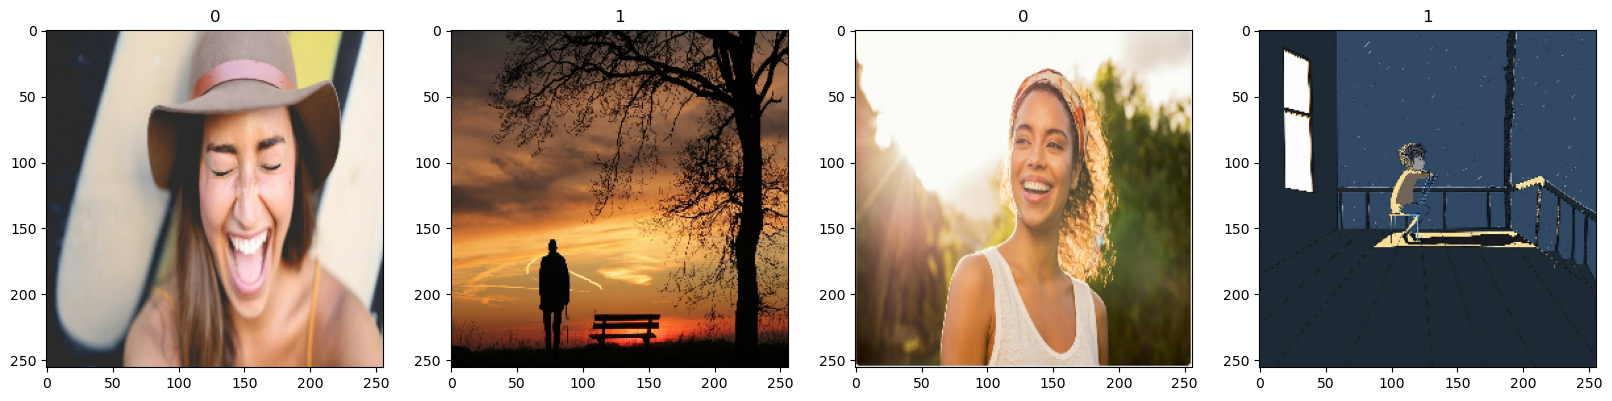

In [14]:
# check 0 and 1 labels

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [15]:
# dividing by 255 scales the images between 0 and 1 manually

scaled = batch[0] / 255

# Step 2: Preprocessing (Scale & Split)

## Scale Data

In [16]:
# scale data in pipeline
# x = images
# y = target labels

data = data.map(lambda x,y: (x/255, y))

In [17]:
# to get this to work properly, I made sure that all image dimensions were above 256

scaled_iterator = data.as_numpy_iterator()

In [18]:
batch = scaled_iterator.next()

In [19]:
batch[0].max()

1.0

In [20]:
len(data)

5

## Split Data

In [21]:
#training sizes
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)

# post-training
test_size = int(len(data)*.1)+1

# print
print(train_size, val_size, test_size)

3 1 1


In [22]:
# making the sets

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [23]:
print(len(train), len(val), len(test))

3 1 1


# Step 3: Deep Model (Build, Train, Plot)

## Build Deep Learning Model

In [24]:
# import librarites

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [25]:
# create model

model = Sequential()

In [26]:
# add the layers

#input layer (requested by keras)
model.add(Input(shape=(256,256,3)))

# convolution layer
#   16 filters (each detecting feature)
#   kernel size: 3x3 pixels in size
#   stride of 1 (moves 1 pixel at a time)
#   relu activation
#   set inputshape with color channels
model.add(Conv2D(16, (3,3), 1, activation='relu'))
# max pooling layer
#   takes max value from 2x2 pixel region (reduces image sizes by half)
model.add(MaxPooling2D())

# convolution layer and max pooling layer
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# convolution layer and max pooling layer
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# eliminates channel value and condenses to a single value
model.add(Flatten())

# fully-connected layers
#   256 neurons activated by relu
#   1 output using sigmoid (either 0 or 1)
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [27]:
# compile the model
#   use adam opptimizer
#   loss uses binarycrossentropy
#   track accuracy

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [28]:
# summary
#   Param # = 0 means it is not a trainable layer

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,692,001 (14.08 MB)

 Trainable params: 3,692,001 (14.08 MB)

 Non-trainable params: 0 (0.00 B)

## Train Deep Learning Model

In [29]:
# create log directory

logdir = 'logs'

In [30]:
# create callback

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
# fit model
hist = model.fit(
    train,
    epochs=20,
    validation_data=val,
    callbacks=[tensorboard_callback]
)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 917ms/step - accuracy: 0.5260 - loss: 1.1840 - val_accuracy: 0.5000 - val_loss: 0.8658
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 969ms/step - accuracy: 0.5521 - loss: 0.7553 - val_accuracy: 0.6875 - val_loss: 0.6199
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 757ms/step - accuracy: 0.6380 - loss: 0.6388 - val_accuracy: 0.8125 - val_loss: 0.5810
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 831ms/step - accuracy: 0.8216 - loss: 0.5808 - val_accuracy: 0.8438 - val_loss: 0.5530
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 836ms/step - accuracy: 0.7357 - loss: 0.5711 - val_accuracy: 0.7500 - val_loss: 0.5282
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 794ms/step - accuracy: 0.7617 - loss: 0.4901 - val_accuracy: 0.8438 - val_loss: 0.3870
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 894ms/step - accuracy: 0.8516 - loss: 0.3949 - val_accuracy: 0.8438 - val_loss: 0.3094
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step - accuracy: 0.7982 - loss: 0.4021 - val_accuracy: 0.8438 - val_loss:

## Plot Deep Learning Model Performance

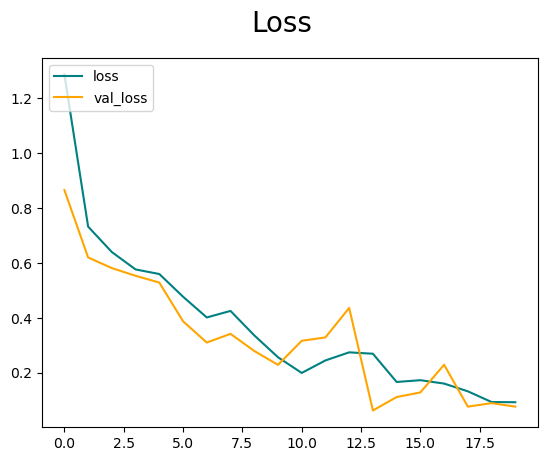

<Figure size 640x480 with 0 Axes>

In [32]:
# plot

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()
plt.savefig("deep_learning_model_loss.png")

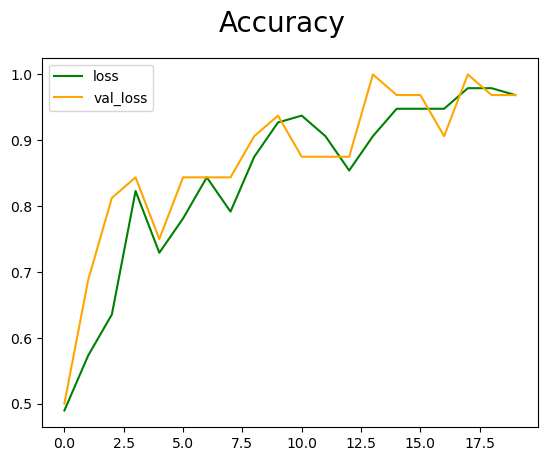

<Figure size 640x480 with 0 Axes>

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='green', label='loss')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_loss')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()
plt.savefig("deep_learning_model_accuracy.png")

# Evaluate

## Evaluate

In [34]:
# import libraries

from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [35]:
# metrics

precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [36]:
# make predictions

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

print(f'Precision:{precision.result().numpy()}, Recall:{recall.result().numpy()}, Accuracy:{accuracy.result().numpy()}') 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
Precision:1.0, Recall:1.0, Accuracy:1.0


## Test

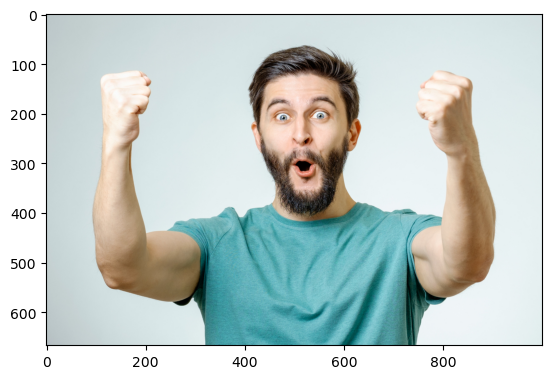

In [69]:
# test on data outside that batch

img = cv2.imread('happy_test.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

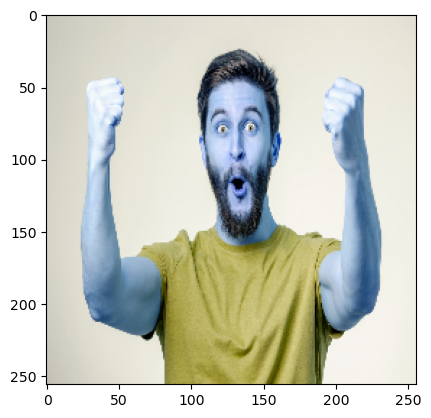

In [70]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [71]:
resize.shape

TensorShape([256, 256, 3])

In [72]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [73]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [74]:
yhat

array([[0.14993672]], dtype=float32)

In [75]:
if yhat > 0.5:
    print(f'Sad!')
else:
    print(f'Happy!')

Happy!


# Save Model

In [77]:
# save model

from tensorflow.keras.models import load_model
model.save(os.path.join('models','happy_sad_model.h5'))

In [78]:
# load model

loaded_model = load_model(os.path.join('models', 'happy_sad_model.h5'))

In [81]:
# predict using loaded model

yhat_loaded = loaded_model.predict(np.expand_dims(resize/255, 0))

if yhat_loaded > 0.5:
    print(f'Sad!')
else:
    print(f'Happy!')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Happy!
